experiment: l0 loss


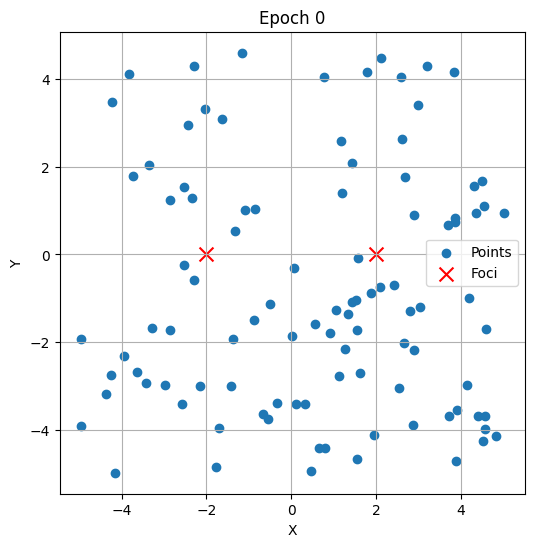

Epoch 1: cannot backprop l0 loss (element 0 of tensors does not require grad and does not have a grad_fn)


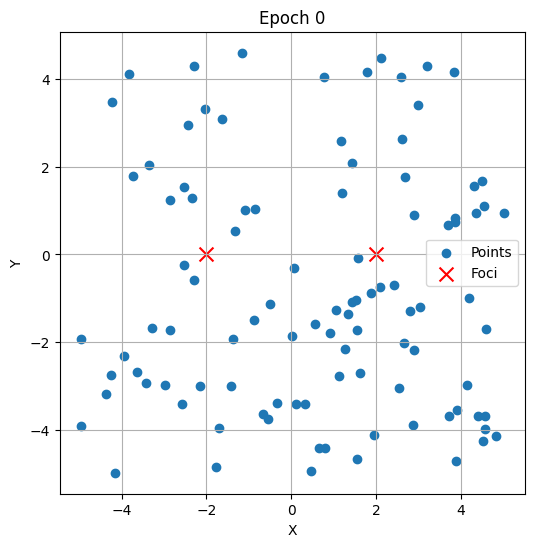

Finished l0 in 0.28 seconds
experiment: l1 loss


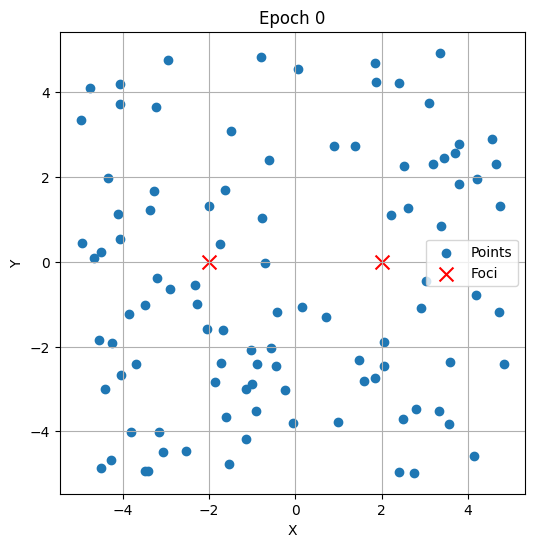

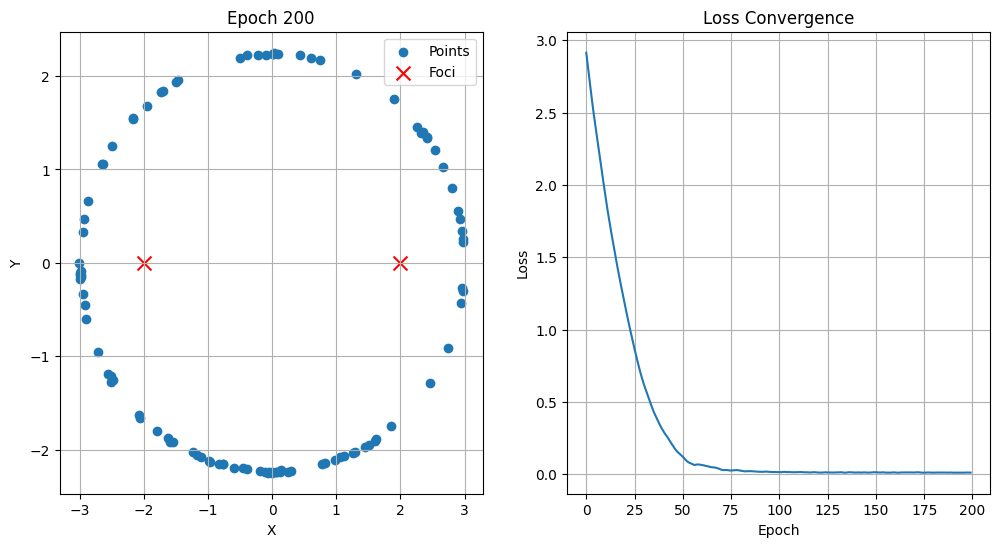

Epoch 200: Loss = 0.010530


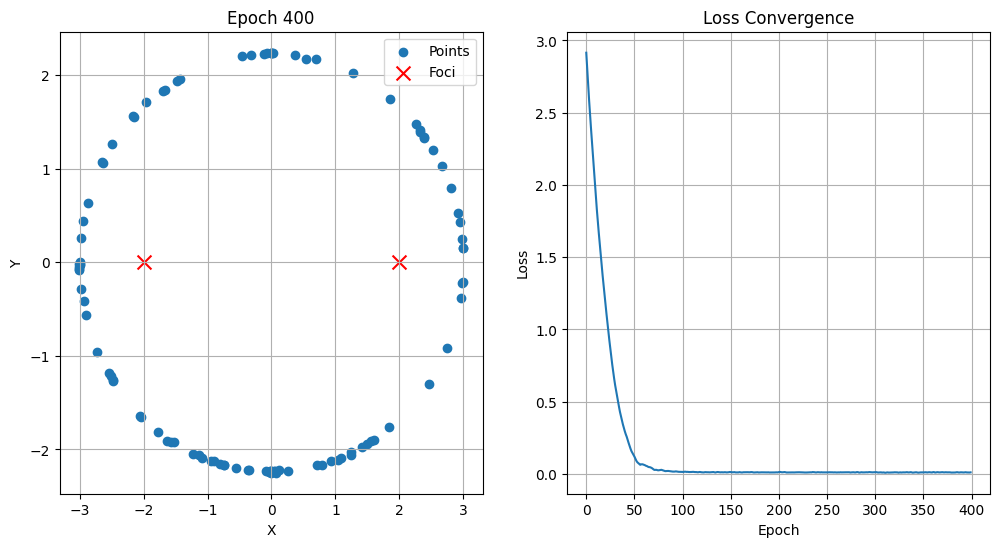

Epoch 400: Loss = 0.010860


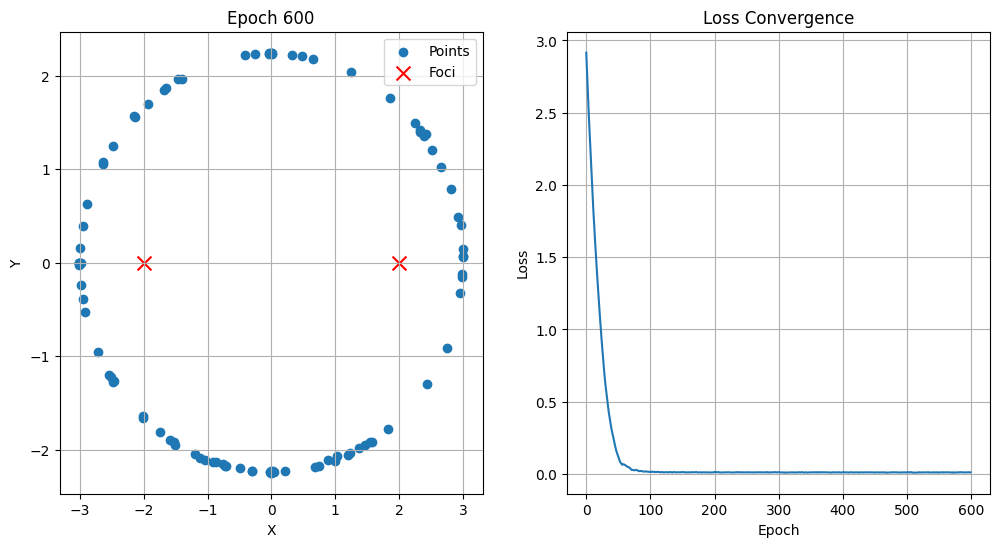

Epoch 600: Loss = 0.010691


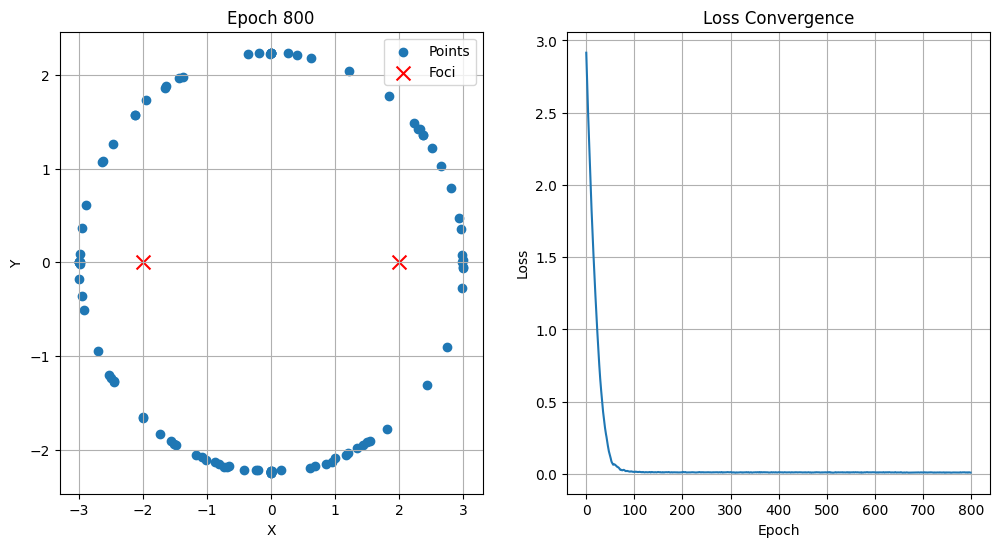

Epoch 800: Loss = 0.009045


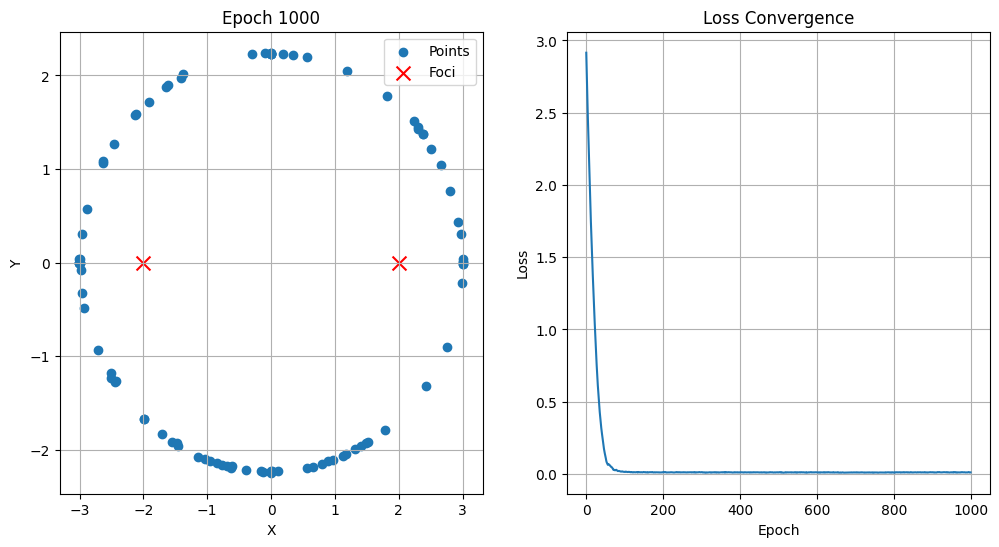

Epoch 1000: Loss = 0.010449


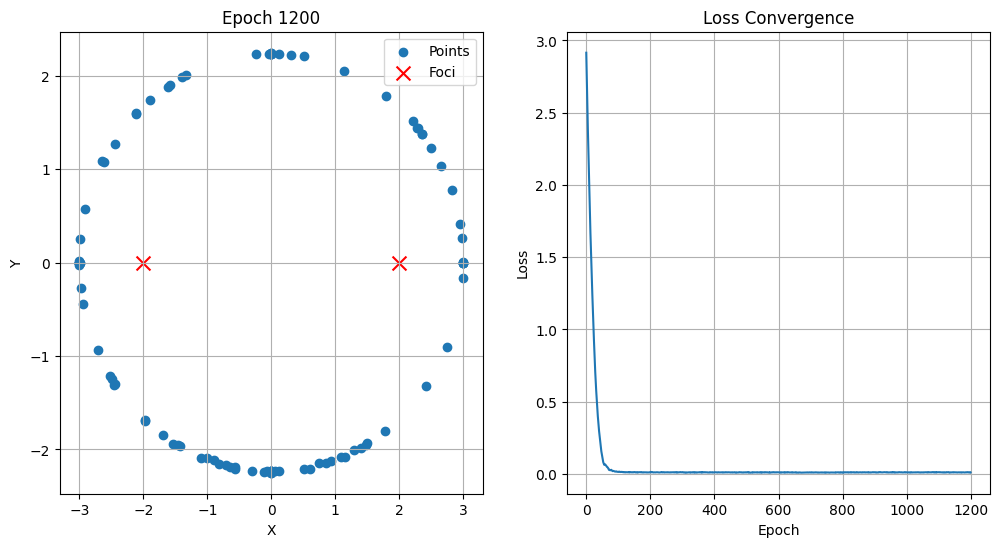

Epoch 1200: Loss = 0.010623


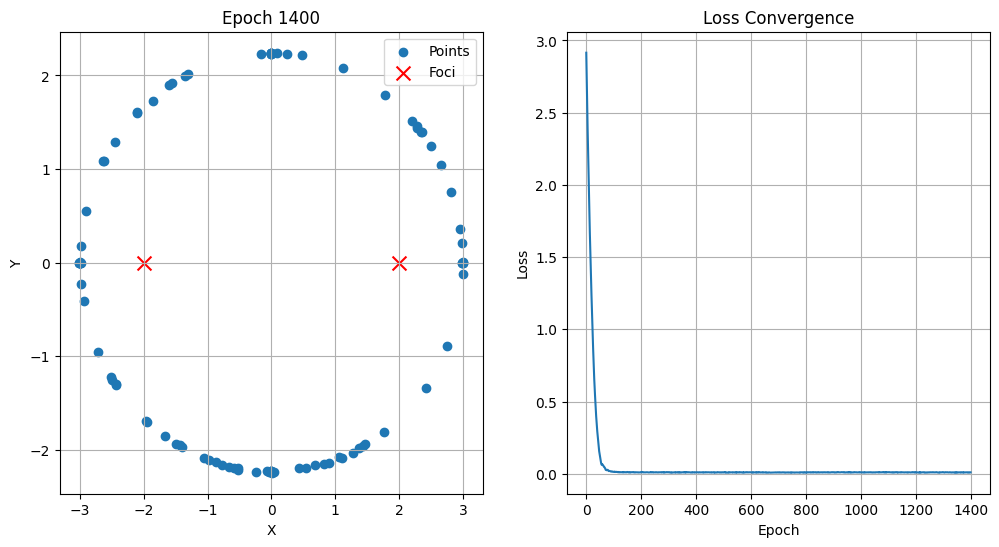

Epoch 1400: Loss = 0.010570


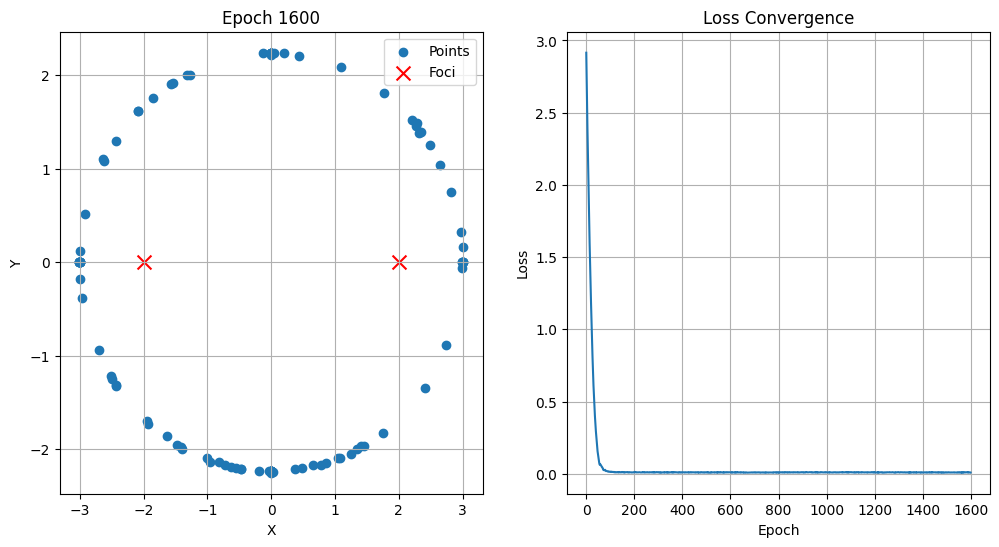

Epoch 1600: Loss = 0.009600


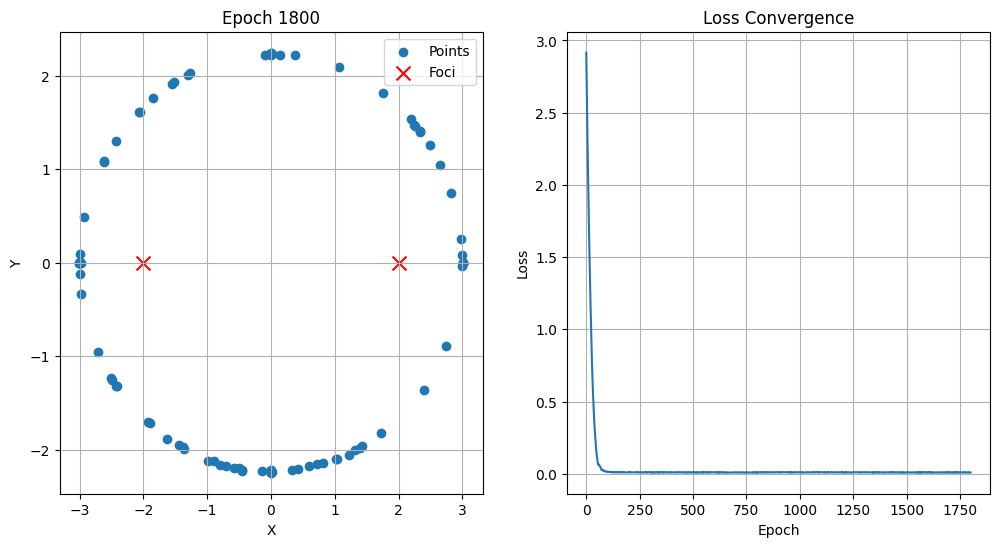

Epoch 1800: Loss = 0.009824


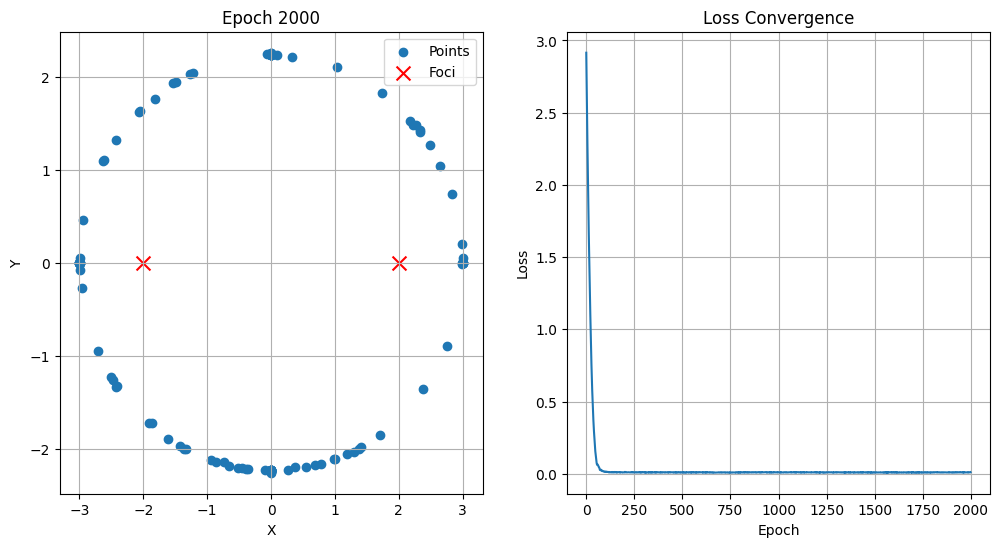

Epoch 2000: Loss = 0.011175


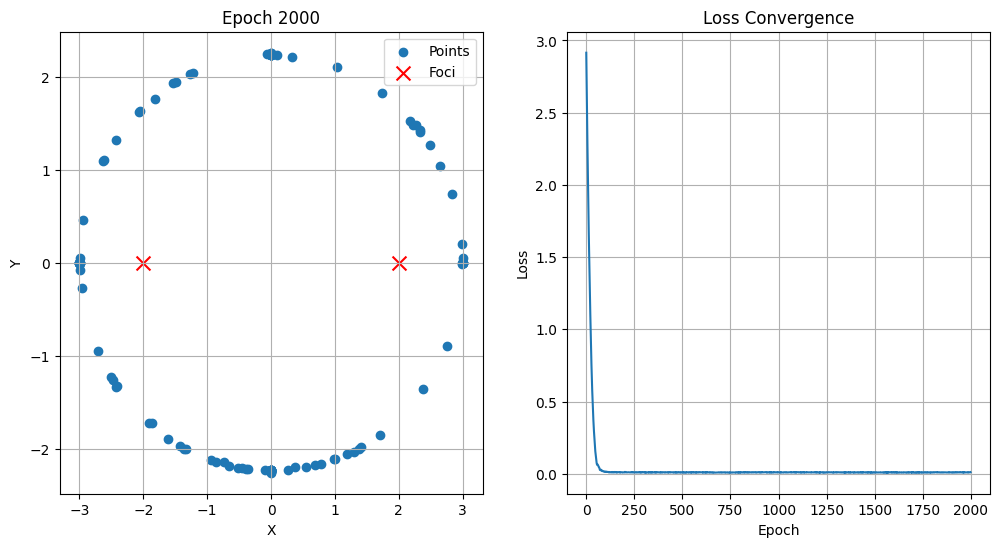

Finished l1 in 11.24 seconds
experiment: linf loss


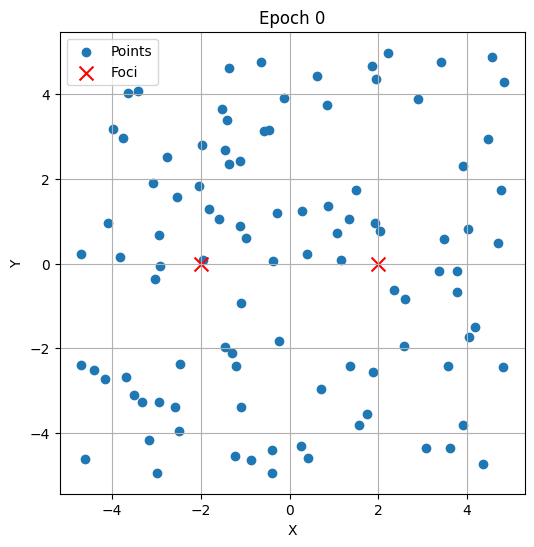

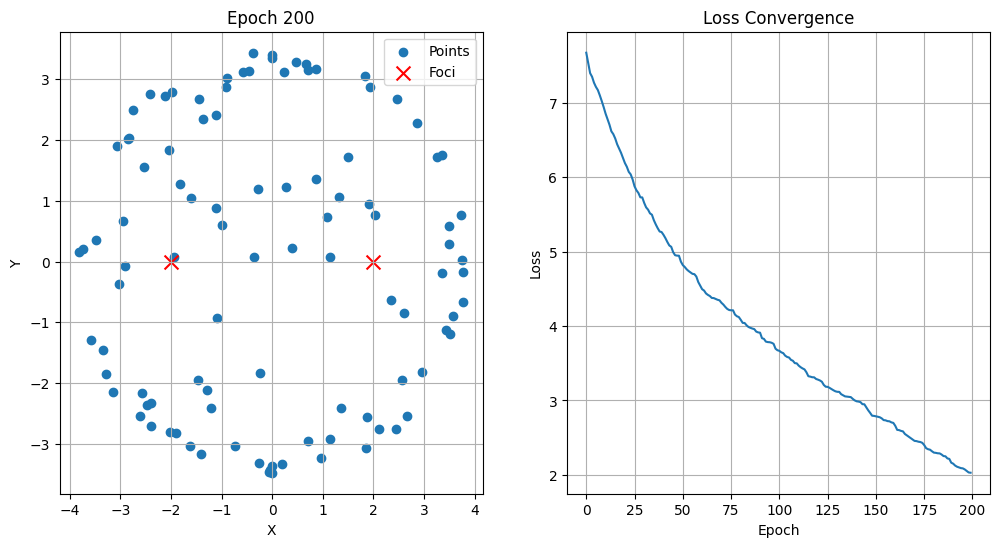

Epoch 200: Loss = 2.028839


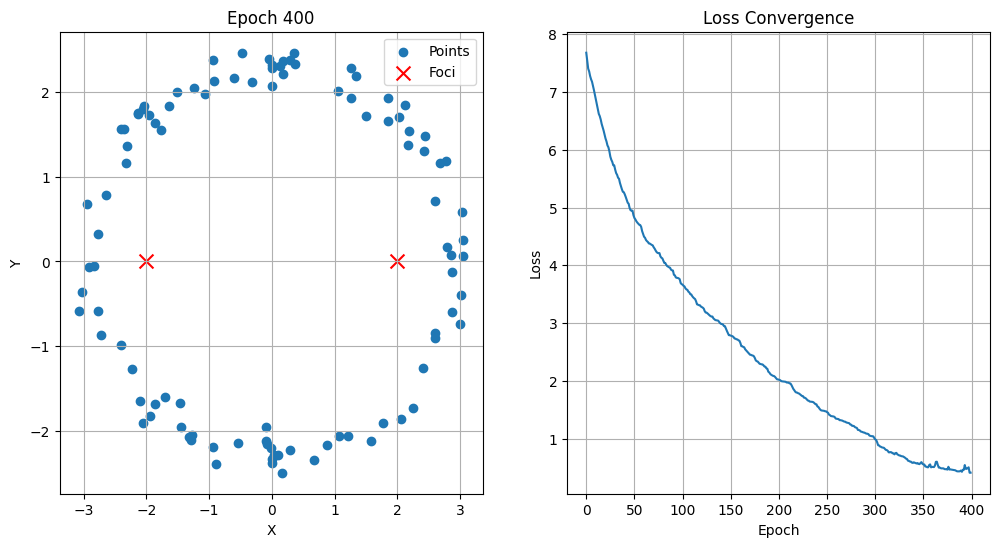

Epoch 400: Loss = 0.417572


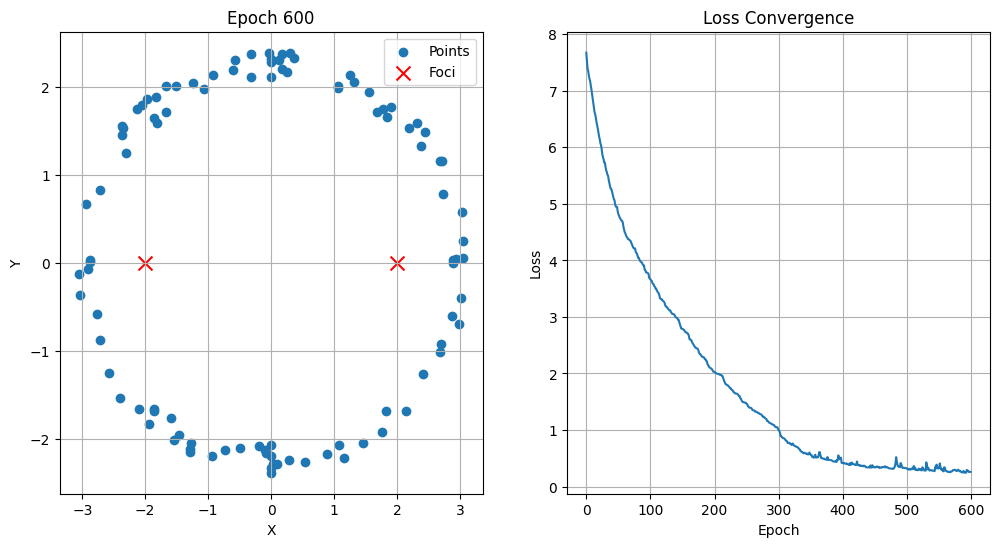

Epoch 600: Loss = 0.257516


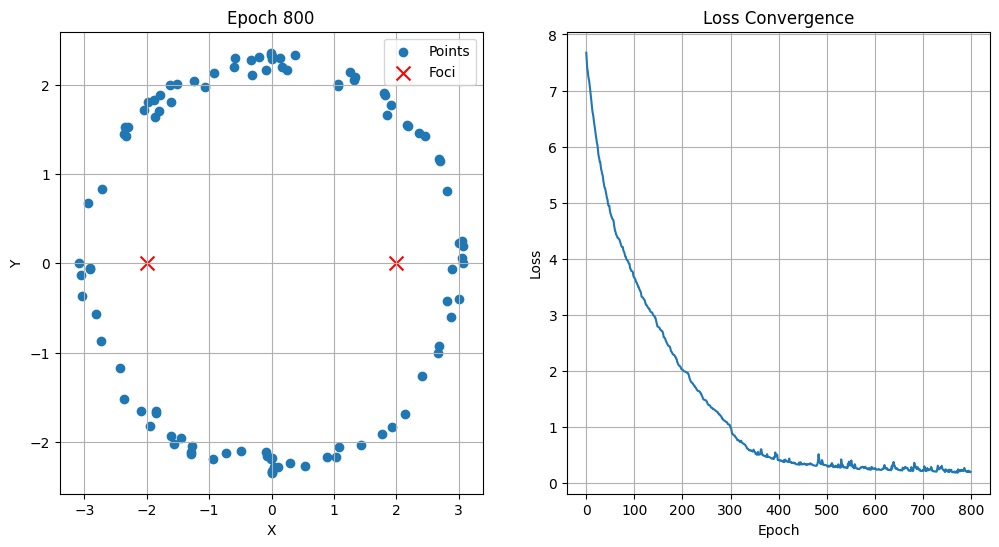

Epoch 800: Loss = 0.204410


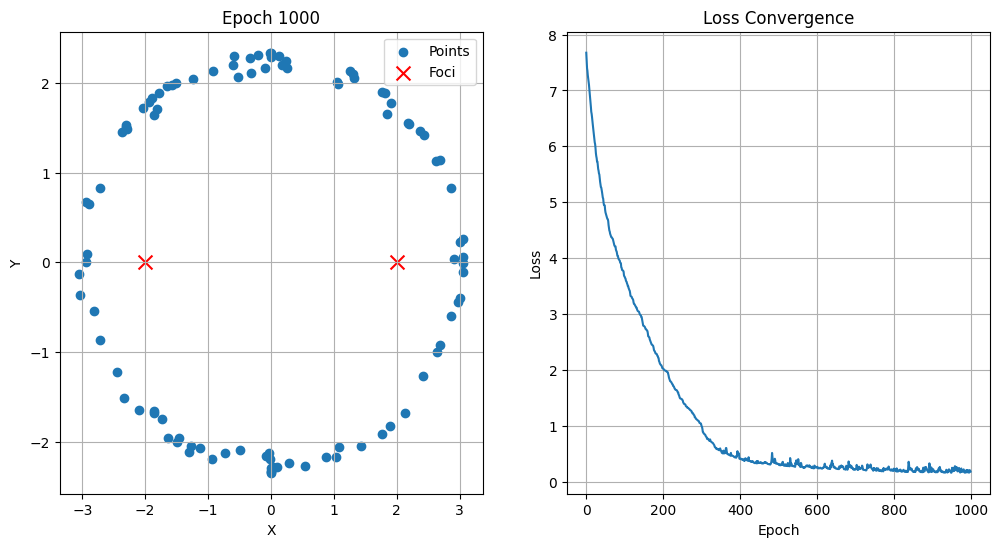

Epoch 1000: Loss = 0.185670


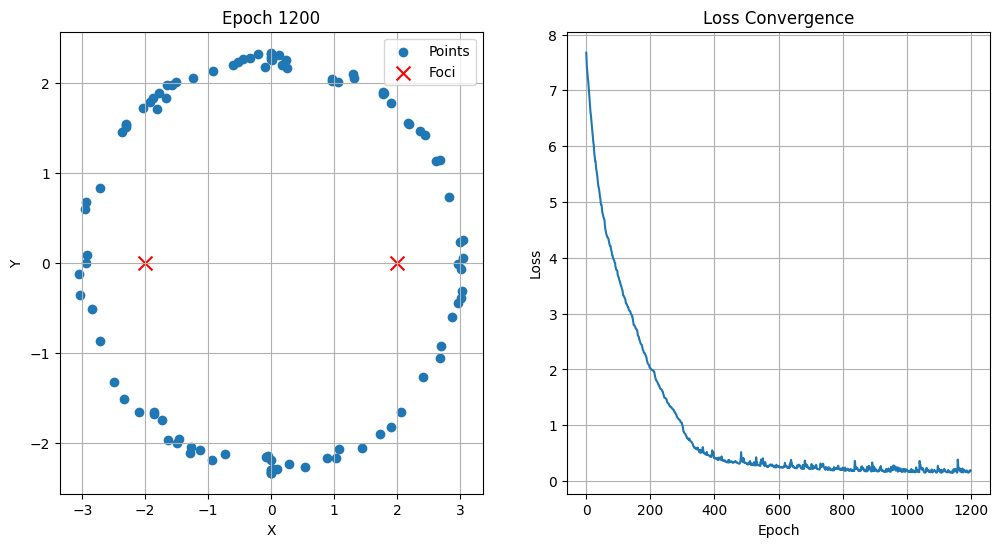

Epoch 1200: Loss = 0.185674


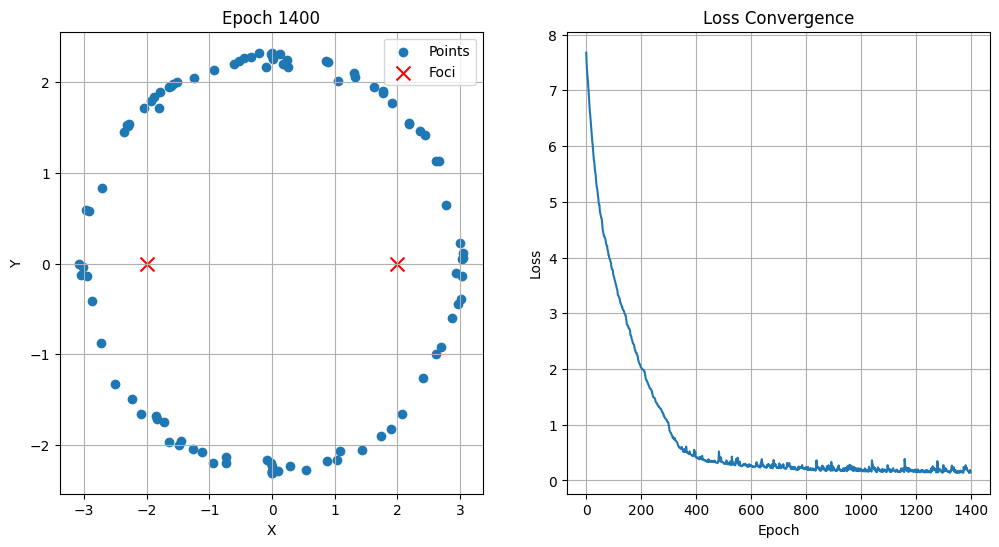

Epoch 1400: Loss = 0.149502


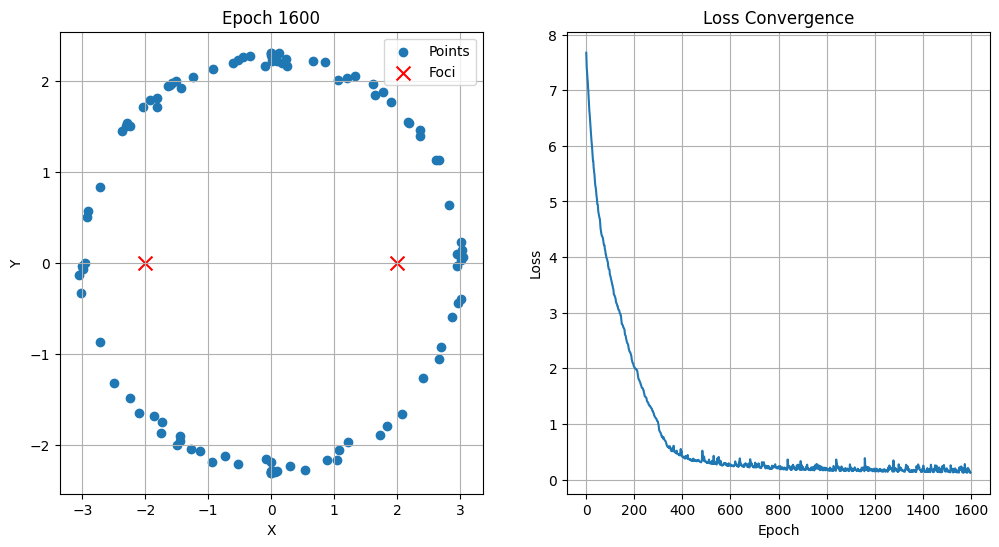

Epoch 1600: Loss = 0.129036


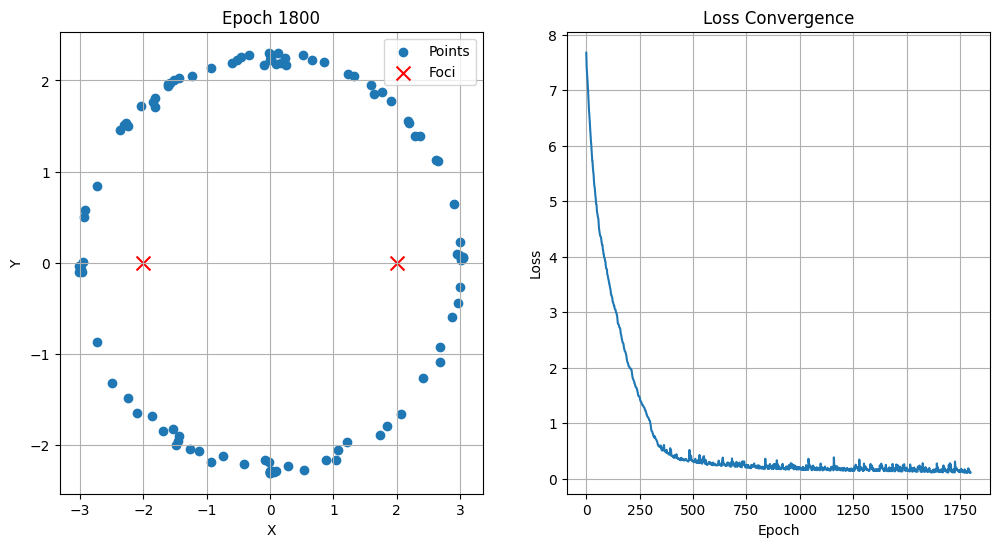

Epoch 1800: Loss = 0.113022


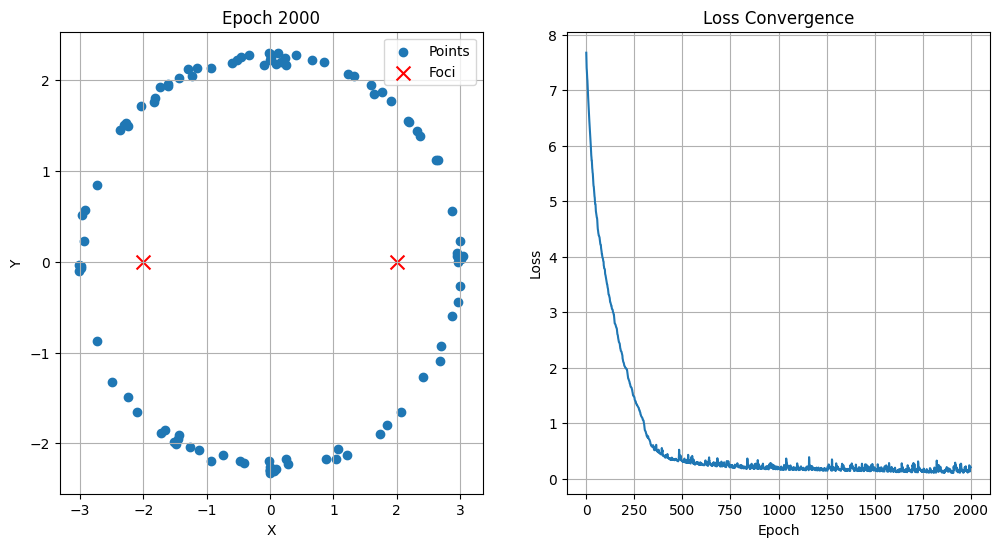

Epoch 2000: Loss = 0.206985


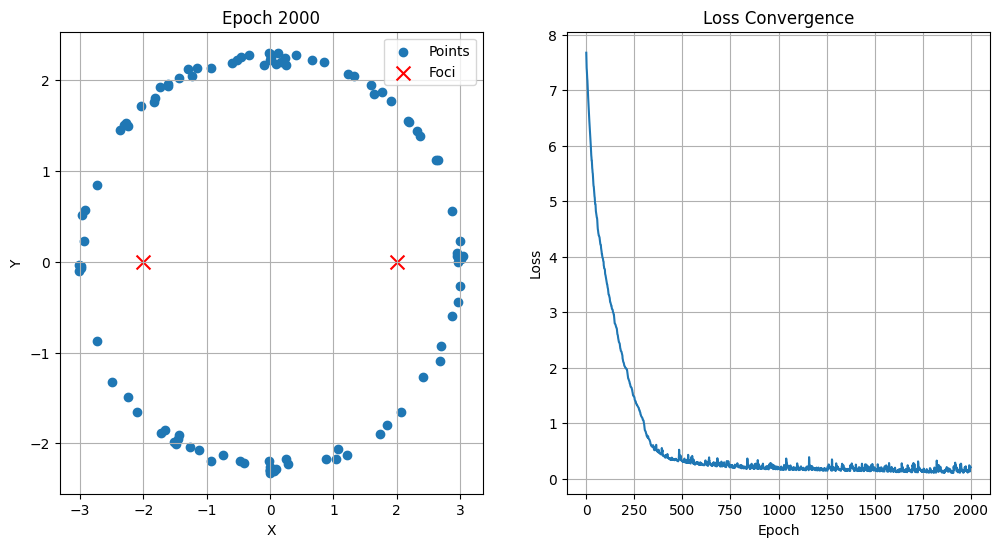

Finished linf in 12.43 seconds


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# plotting function
def plot_results(epoch, trajectories, loss_history=None):
    draw_loss = loss_history is not None and len(loss_history) > 0
    if draw_loss:
        fig, (ax_pts, ax_loss) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, ax_pts = plt.subplots(1, 1, figsize=(6, 6))
        ax_loss = None

    # Plot scatter of points and foci
    pts = np.array([traj[-1] for traj in trajectories])
    ax_pts.scatter(pts[:, 0], pts[:, 1], label="Points")
    ax_pts.scatter([-2, 2], [0, 0], color='red', marker='x', s=100, label="Foci")
    # Draw movement traces
    for traj in trajectories:
        arr = np.array(traj)
        ax_pts.plot(arr[:, 0], arr[:, 1], color='gray', linewidth=0.5)
    ax_pts.set_xlabel('X')
    ax_pts.set_ylabel('Y')
    ax_pts.set_title(f"Epoch {epoch}")
    ax_pts.legend()
    ax_pts.grid()

    # Plot loss history if available
    if draw_loss:
        ax_loss.plot(loss_history)
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.set_title("Loss Convergence")
        ax_loss.grid()

    plt.show()


# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([2.0, 0.0])   # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# hyperparameters
num_points = 100
LR = 0.05
num_epochs = 2000
plot_interval = 200

for loss_type in ("l0", "l1", "linf"):
    print(f"experiment: {loss_type} loss")

    # random 2D points
    points = torch.rand((num_points, 2)) * 10 - 5
    points.requires_grad_(True)

    # optimizer
    optimizer = torch.optim.Adam([points], lr=LR)

    # trajectories and loss history
    trajectories = [[] for _ in range(num_points)]
    loss_history = []

    # initial positions
    for i in range(num_points):
        trajectories[i].append(points[i].detach().numpy())

    # Plot
    plot_results(0, trajectories, None)
    # Start timing
    start_time = time.time()

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # zero-out all gradients
        optimizer.zero_grad()

        # distances to both foci
        dist1 = torch.norm(points - focus1, dim=1)
        dist2 = torch.norm(points - focus2, dim=1)
        eps = dist1 + dist2 - constant_sum

        # Compute selected loss
        if loss_type == "l0":
            # l0
            loss = torch.mean((eps != 0).float())
        elif loss_type == "l1":
            # l1
            loss = torch.mean(torch.abs(eps))
        else:
            # linf
            loss = torch.max(torch.abs(eps))

        # backward, gradient calculation
        try:
            loss.backward()
            optimizer.step()
        except RuntimeError as e:
            print(f"Epoch {epoch}: cannot backprop {loss_type} loss ({e})")
            break

        # Store loss and current positions
        loss_history.append(loss.item())
        for i in range(num_points):
            trajectories[i].append(points[i].detach().numpy())

        # Plot results every plot_interval epochs
        if epoch % plot_interval == 0:
            plot_results(epoch, trajectories, loss_history)
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    # Final plot
    if loss_history:
        plot_results(epoch, trajectories, loss_history)
    else:
        plot_results(0, trajectories, None)

    # End timing
    elapsed_time = time.time() - start_time
    print(f"Finished {loss_type} in {elapsed_time:.2f} seconds")


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
# Fix the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define ellipse parameters
focus1 = torch.tensor([-2.0, 0.0])  # First focus
focus2 = torch.tensor([ 2.0, 0.0])  # Second focus
constant_sum = 6.0  # The sum of distances to the two foci

# Common hyperparameters
num_points = 100
LR         = 0.05
num_epochs = 2000
frames     = 60
step       = max(1, num_epochs // frames)

# Function to compute trajectories for a given loss_type
def compute_trajectories(loss_type):
    points = torch.rand((num_points, 2)) * 10 - 5
    points.requires_grad_(True)
    optimizer = torch.optim.Adam([points], lr=LR)

    traj = []
    for epoch in range(1, num_epochs + 1):
        optimizer.zero_grad()
        dist1 = torch.norm(points - focus1, dim=1)
        dist2 = torch.norm(points - focus2, dim=1)
        eps   = dist1 + dist2 - constant_sum

        if loss_type == "l1":
            loss = torch.mean(torch.abs(eps))
        else:  # "linf"
            loss = torch.max(torch.abs(eps))

        loss.backward()
        optimizer.step()

        if epoch % step == 0:
            traj.append(points.detach().cpu().numpy().copy())
    return traj

# Prepare trajectories for both losses
traj_l1   = compute_trajectories("l1")
traj_linf = compute_trajectories("linf")

# Function to create animation for trajectories
def make_animation(traj, loss_type):
    fig, ax = plt.subplots(figsize=(6,6))
    scat = ax.scatter([], [], s=20)
    ax.scatter([focus1[0], focus2[0]], [focus1[1], focus2[1]],
               c='red', marker='x', s=100, label='Foci')
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)
    ax.legend()

    def init():
        scat.set_offsets(np.empty((0,2)))
        ax.set_title(f'{loss_type.upper()} – Epoch 0')
        return scat,

    def animate(i):
        pts = traj[i]
        scat.set_offsets(pts)
        epoch = (i+1) * step
        ax.set_title(f'{loss_type.upper()} – Epoch {epoch}')
        return scat,

    anim = FuncAnimation(
        fig, animate,
        frames=len(traj),
        init_func=init,
        blit=True,
        interval=100
    )
    plt.close(fig)
    return anim

# Create animations
anim_l1   = make_animation(traj_l1,   "l1")
anim_linf = make_animation(traj_linf, "linf")

# Display
display(HTML(anim_l1.to_html5_video()))
display(HTML(anim_linf.to_html5_video()))



(<IPython.core.display.HTML object>, <IPython.core.display.HTML object>)

Dla wszystkich funkcji loss obliczamy pochodne cząstkowe (points.requires_grad = True i loss.backward())
$$
\frac{\partial L}{\partial \epsilon_i}
$$  
dla każdego błędu  
$$
\epsilon_i = d_{i1} + d_{i2} - C
$$  
względem współrzędnych punktu $p_i$:  
$$
\frac{\partial L}{\partial p_i}
= \frac{\partial L}{\partial \epsilon_i}\;\frac{\partial \epsilon_i}{\partial p_i}
$$  


Dla $L^{(1)}$:  
$$
L = \frac{1}{N}\sum_{i=1}^N |\epsilon_i|
$$
$$
\frac{\partial L}{\partial \epsilon_i}
= \frac{1}{N}\,\mathrm{sign}(\epsilon_i)
=
\begin{cases}
+\tfrac{1}{N}, & \epsilon_i > 0\\
-\tfrac{1}{N}, & \epsilon_i < 0
\end{cases}
$$  

Dla $L^{(\infty)}$:  
$$
L = \max_i |\epsilon_i|
$$  
czyli gradient jest różny od zera tylko dla największej wartości $\epsilon_j$:  
$$
\frac{\partial L}{\partial \epsilon_j} = \mathrm{sign}(\epsilon_j)
$$
$$
\frac{\partial L}{\partial \epsilon_i} = 0 \quad (i \neq j)
$$  

Dla $L^{(0)}$:  
$$
L = \frac{1}{N}\sum_{i=1}^N \mathbf{1}(\epsilon_i \neq 0)
$$  
taka funkcja prawie wszędzie nie jest różniczkowalna, czyli:  
$$
\frac{\partial L}{\partial \epsilon_i} = 0
$$  
czyli nie ma sygnału do przesunięcia punktów.

pochodna względem współrzędnych punktu:  
$$
\frac{\partial \epsilon_i}{\partial p_i}
= \frac{p_i - \mathrm{focus}_1}{\|p_i - \mathrm{focus}_1\|}
+ \frac{p_i - \mathrm{focus}_2}{\|p_i - \mathrm{focus}_2\|}
$$  

czyli gradient, którego używamy do przesunięcia punktu, to:
$$
\frac{\partial L}{\partial p_i}
$$  

Przy próbie zastosowania normy $l_0$ kod wyrzucił błąd o braku grad\_fn. To dlatego, że definicja $l_0$ ma w sobie funkcję $\mathbf{1}(\epsilon_i \neq 0)$, która jest funkcją skokową (Charakterystyka skokowa), z tego powodu gradient jest wszędzie zerowy i nie ma "sygnału", czyli algorytm "nie wie", w którą stronę i o ile przemieścić punkty. (dlatego trening dla $l_0$ nie działa). Aby $l_0$ dało się trenować za pomocą gradientu, można zastąpić skokową charakterystykę gładką aproksymacją $\epsilon^2/(\epsilon^2+δ)$ z małym δ, co daje niezerowy gradient nawet przy małych błędach: dla $|\epsilon|>>\sqrt{\delta}$ mamy: $\frac{\epsilon^2}{\epsilon^2+\delta} \approx \frac{\epsilon^2}{\epsilon^2}$, dla $\epsilon^2 << \delta$ mamy $\frac{\epsilon^2}{\epsilon^2+\delta} \approx \frac{\epsilon^2}{\delta}\rightarrow 0$.

Przy normie $l_1$ loss szybko spadł do około 0,02, a potem oscylował między 0,01 a 0,02, tymczasem punkty już prawie idealnie leżały na elipsie. Dzieje się tak, bo gradient $\frac{\partial L}{\partial \epsilon_i}$ to zawsze $+1$ lub $–1$, niezależnie od wielkości błędu punkty przeskakują obok idealnej elipsy (jej punktów) i loss nie zbiega do zera. Aby zmniejszyć oscylacje dla $l_1$ można obniżyć learning rate.

Przy normie $l_∞$ loss na początku wynosił około 7,5 i po 2000 epokach spadł do około 0,1-0,2, ale dość mocno ocylując. Funkcja $\max_i |\epsilon_i|$ zwraca tylko największy błąd, czyli każda iteracja zmienia tylko jedną "najgorszą" odległość, a pozostałe punkty się nie ruszają, co znacznie spowalnia algorytm. Dlatego trening trwa długo i po 2000 epokach loss nie zbiega do 0.


